In [7]:
#!pip install pandas-datareader
from helper import *
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import json
import pandas_datareader.data as web
import bs4 as bs
import pickle
import requests
from collections import OrderedDict
import pytz

%matplotlib inline

In [8]:
def get_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

    soup = bs.BeautifulSoup(resp.text, "lxml")
    table = soup.find('table', {'class':'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        ticker = ticker[:-1]
        tickers.append(ticker)

    
    tickers.sort()
    tickers.remove('BF.B')
    tickers.remove('BRK.B')
    tickers.remove('CARR')
    tickers.remove('DPZ')
    tickers.remove('DXCM')
    tickers.remove('OTIS')
    tickers.remove('WST')
    
    return tickers
            
def buy_sell_hold(*args):
    cols = [c for c in args]
    #requirement = 0.025
    for col in cols:
        if col > 0.027:
            return 1
        if col < -0.022:
            return -1
    return 0

def get_n_day_momentum(n_days, data):
    close = data['Adj Close']
    return close - close.shift(n_days)

def get_macd(ewm1, ewm2, data):
    df = data
    exp1 = df['Adj Close'].ewm(span=ewm1, adjust=False).mean()
    exp2 =  df['Adj Close'].ewm(span=ewm2, adjust=False).mean()
    return exp1-exp2

def get_rsi(window_length, data):
    df = data
    delta = df['Adj Close'].diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up1 = up.ewm(span=window_length).mean()
    roll_down1 = down.abs().ewm(span=window_length).mean()
    RS = roll_up1 / roll_down1
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

In [9]:
data_indicators = OrderedDict()
stock_data = pd.DataFrame()
hm_days = 7
tickers = get_sp500_tickers()
for ticker in tickers:
    df = pd.read_csv("stocks_dfs/{}.csv".format(ticker), index_col=0, parse_dates=['Date'])
    df = df[['Adj Close','Volume']]
    df.fillna(0, inplace=True)
    for i in range(1, hm_days+1):
        df['{}d'.format(i)] = (df['Adj Close'].shift(-i) - df['Adj Close']) / df['Adj Close']
        
    df['50MA'] = df['Adj Close'].rolling(50).mean()
    df['25MA'] = df['Adj Close'].rolling(25).mean()
    df['10MA'] = df['Adj Close'].rolling(10).mean()
    df['5MA'] = df['Adj Close'].rolling(5).mean()

    df['50STD'] = df['Adj Close'].rolling(50).std()
    df['25STD'] = df['Adj Close'].rolling(25).std()
    df['10STD'] = df['Adj Close'].rolling(10).std()

    df['50UBB'] = df['50MA'] + (df['50STD'] * 2)
    df['25UBB'] = df['25MA'] + (df['25STD'] * 2)

    df['50LBB'] = df['50MA'] - (df['50STD'] * 2)
    df['25LBB'] = df['25MA'] - (df['25STD'] * 2)
    
    df['RSI5'] = get_rsi(5,df)
    df['RSI10'] = get_rsi(10,df)
    df['RSI25'] = get_rsi(25,df)
    df['RSI50'] = get_rsi(50,df)
    
    df['MACD5-10'] = get_macd(5,10,df)
    df['MACD5-25'] = get_macd(5,25,df)
    df['MACD5-50'] = get_macd(5,50,df)

    df['MACD10-25'] = get_macd(10,25,df)
    df['MACD10-50'] = get_macd(10,50,df)

    df['MACD25-50'] = get_macd(25,50,df)
    
    df['5DMomentum'] = get_n_day_momentum(5,df)
    df['10DMomentum'] = get_n_day_momentum(10,df)
    df['25DMomentum'] = get_n_day_momentum(25,df)
    df['50DMomentum'] = get_n_day_momentum(50,df)


    
    data_indicators[ticker] = df
    

stock_data = pd.concat(data_indicators.values(),keys=tickers,names=['Ticker','Date'])

stock_data = stock_data.swaplevel()
stock_data = stock_data.sort_index()

In [10]:
stock_data['target'] = list(map( buy_sell_hold,
                                               stock_data['1d'.format(ticker)],
                                               stock_data['2d'.format(ticker)],
                                               stock_data['3d'.format(ticker)],
                                               stock_data['4d'.format(ticker)],
                                               stock_data['5d'.format(ticker)],
                                               stock_data['6d'.format(ticker)],
                                               stock_data['7d'.format(ticker)] ))

In [11]:
stock_data.drop(columns=['1d', '2d','3d','4d','5d','6d','7d'], inplace=True)
stock_data.replace([np.inf, -np.inf], np.nan, inplace = True)
stock_data.fillna(0, inplace=True)
stock_data = stock_data.loc[(slice('2010-03-16','2019-12-31')),:]
stock_data.head()

Adj Close       Volume       50MA       25MA       10MA  \
Date       Ticker                                                            
2010-03-16 A       21.820704    3285900.0  20.141775  20.705770  21.645719   
           AAL      7.325101    5915400.0   5.946059   6.822809   7.226114   
           AAP     41.161922     843400.0  39.806780  40.507213  40.935180   
           AAPL    27.833111  111727000.0  25.663924  25.941177  27.359656   
           ABC     24.367403    4210300.0  23.548246  23.958760  24.112215   

                         5MA     50STD     25STD     10STD      50UBB  ...  \
Date       Ticker                                                      ...   
2010-03-16 A       21.858573  0.961589  0.932832  0.303887  22.064953  ...   
           AAL      7.428802  0.970238  0.475839  0.240773   7.886535  ...   
           AAP     41.078227  1.027993  0.881267  0.261797  41.862767  ...   
           AAPL    27.907019  1.173133  1.326524  0.761078  28.010189  ...   
           ABC     24.087297  0.604464  0.298869  0.166858  24.757174  ...   

                   MACD5-25  MACD5-50  MACD10-25  MACD10-50  MACD25-50  \
Date       Ticker                                                        
2010-03-16 A       0.830135  1.242865   0.625629   1.038359   0.412730   
           AAL     0.574131  1.170651   0.457157   1.053676   0.596519   
           AAP     0.585189  0.970875   0.411384   0.797070   0.385686   
           AAPL    1.321352  1.690658   0.896776   1.266081   0.369306   
           ABC     0.178486  0.452716   0.154857   0.429087   0.274230   

                   5DMomentum  10DMomentum  25DMomentum  50DMomentum  target  
Date       Ticker                                                             
2010-03-16 A         0.097935     0.692101     2.755337          0.0       1  
           AAL       0.056563     0.084847     1.734644          0.0      -1  
           AAP       0.350330     0.934185     1.449917          0.0       1  
           AAPL      0.177330     1.934494     3.761101          0.0       0  
           ABC       0.317907    -0.085918     1.279705          0.0       1  

[5 rows x 28 columns]

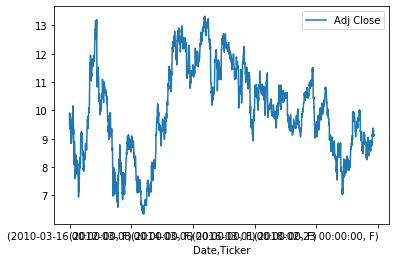

In [12]:
stock_data.loc[(slice(None), 'F'), ['Adj Close']].plot()

In [33]:
stock_data.columns

Index(['Adj Close', 'Volume', '50MA', '25MA', '10MA', '5MA', '50STD', '25STD',
       '10STD', '50UBB', '25UBB', '50LBB', '25LBB', 'RSI5', 'RSI10', 'RSI25',
       'RSI50', 'MACD5-10', 'MACD5-25', 'MACD5-50', 'MACD10-25', 'MACD10-50',
       'MACD25-50', '5DMomentum', '10DMomentum', '25DMomentum', '50DMomentum',
       'target'],
      dtype='object')

In [40]:
columns = ['Adj Close','Volume','50MA','50STD','50UBB','50LBB','RSI50','MACD10-50','50DMomentum']
stock_data[columns].describe()


,Adj Close,Volume,50MA,50STD,50UBB,50LBB,RSI50,MACD10-50,50DMomentum
count,1.177323e+06,1.177323e+06,1.177323e+06,1.177323e+06,1.177323e+06,1.177323e+06,1.177323e+06,1.177323e+06,1.177323e+06
mean,7.650932e+01,4.876650e+06,7.535173e+01,2.989113e+00,8.132995e+01,6.937350e+01,5.314687e+01,8.771127e-01,2.199708e+00
std,1.342939e+02,1.140600e+07,1.319410e+02,5.944948e+00,1.424955e+02,1.216333e+02,8.991140e+00,5.910588e+00,1.598624e+01
min,4.953147e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.632077e+01,0.000000e+00,-2.807349e+02,-8.466899e+02
25%,2.885948e+01,1.032300e+06,2.849276e+01,9.588002e-01,3.089753e+01,2.597500e+01,4.702609e+01,-4.366645e-01,-1.299995e+00
50%,4.868000e+01,2.133700e+06,4.810900e+01,1.680638e+00,5.180006e+01,4.435038e+01,5.338431e+01,5.089797e-01,1.270748e+00
75%,8.277102e+01,4.657100e+06,8.162161e+01,3.076324e+00,8.761682e+01,7.557184e+01,5.941671e+01,1.718487e+00,4.561129e+00
max,3.892890e+03,8.596434e+08,3.710292e+03,2.931788e+02,3.956872e+03,3.505178e+03,1.000000e+02,2.600959e+02,6.795601e+02


In [14]:
def buy_sell_hold(*args):
    cols = [c for c in args]
    #requirement = 0.025
    for col in cols:
        if col > 0.025:
            return 1
        if col < -0.025:
            return -1
    return 0



data = OrderedDict()
stock_data_vis = pd.DataFrame()
hm_days = 7
tickers = get_sp500_tickers()
for ticker in tickers:
    df = pd.read_csv("stocks_dfs/{}.csv".format(ticker), index_col=0, parse_dates=['Date'])
    df = df[['Adj Close','Volume']]
    df.fillna(0, inplace=True)
    for i in range(1, hm_days+1):
        df['{}d'.format(i)] = (df['Adj Close'].shift(-i) - df['Adj Close']) / df['Adj Close']
        
        data[ticker] = df
        
stock_data_vis = pd.concat(data.values(),keys=tickers,names=['Ticker','Date'])

stock_data_vis = stock_data_vis.swaplevel()
stock_data_vis = stock_data_vis.sort_index()

stock_data_vis['Target'] = list(map( buy_sell_hold,
                                               stock_data_vis['1d'.format(ticker)],
                                               stock_data_vis['2d'.format(ticker)],
                                               stock_data_vis['3d'.format(ticker)],
                                               stock_data_vis['4d'.format(ticker)],
                                               stock_data_vis['5d'.format(ticker)],
                                               stock_data_vis['6d'.format(ticker)],
                                               stock_data_vis['7d'.format(ticker)] ))
stock_data_vis.drop(columns=['1d', '2d','3d','4d','5d','6d','7d'], inplace=True)
stock_data_vis.replace([np.inf, -np.inf], np.nan, inplace = True)
stock_data_vis.fillna(0, inplace=True)
stock_data_vis = stock_data_vis.loc[(slice('2010-03-16','2019-12-31')),:]
stock_data_vis.head()

Adj Close       Volume  Target
Date       Ticker                                
2010-03-16 A       21.820704    3285900.0       1
           AAL      7.325101    5915400.0      -1
           AAP     41.161922     843400.0       1
           AAPL    27.833111  111727000.0       0
           ABC     24.367403    4210300.0       1

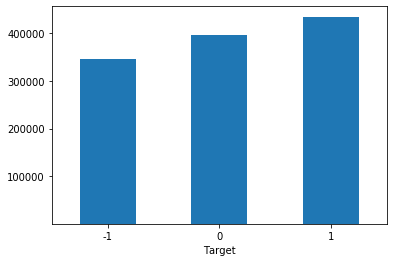

In [15]:
vis2 = stock_data_vis.groupby('Target').count()['Adj Close'].plot(kind='bar',rot=0,yticks=[100000,200000,300000,400000])


In [16]:
stock_data_vis.groupby('Target').count()['Adj Close']


Target
-1    345713
 0    396929
 1    434681
Name: Adj Close, dtype: int64

In [17]:
AAPL = stock_data.loc[(slice(None), 'AAPL'), :]
close = AAPL['Adj Close']
volume = AAPL['Volume']
test_volume = AAPL['Volume'][-252:]

MA_50 = AAPL['50MA']
MA_10 = AAPL['10MA']
STD_50 = AAPL['50STD']
STD_10 = AAPL['10STD']
BBU = AAPL['25UBB']
BBL = AAPL['25LBB']


AAPL.index.values[0][0]
idx = []
for date in AAPL.index:
    idx.append(date[0])

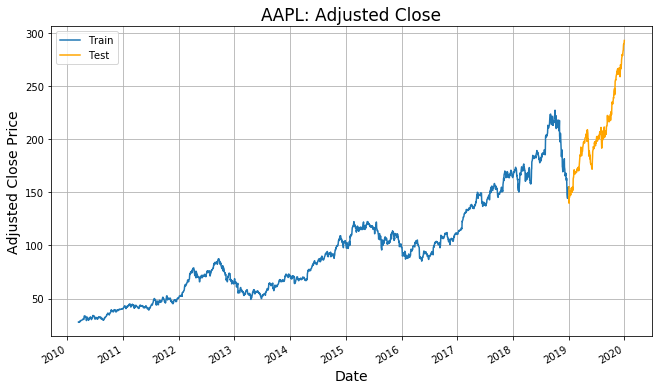

In [19]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot_date(idx[:-252],close[:-252],'-',label='Train')
ax.plot_date(idx[-252:],close[-252:],'-',color='orange',label='Test')
fig.autofmt_xdate()
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.tight_layout()
plt.title('AAPL: Adjusted Close', fontdict= {'fontsize': 17})
plt.xlabel('Date',fontdict= {'fontsize': 14})
plt.ylabel('Adjusted Close Price',fontdict= {'fontsize': 14})
plt.legend(loc=2)

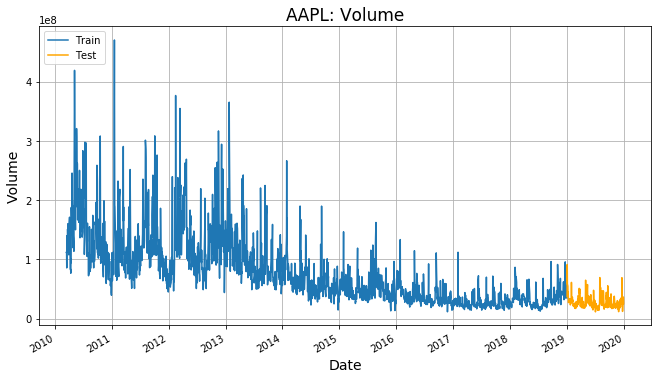

In [20]:
test_idx = idx[-252:]

fig, ax = plt.subplots(figsize=(9,5))
ax.plot_date(idx[:-252],volume[:-252],'-',label='Train')
ax.plot_date(test_idx,test_volume,'-',color='orange',label='Test')

fig.autofmt_xdate()
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.tight_layout()
plt.title('AAPL: Volume', fontdict= {'fontsize': 17})
plt.xlabel('Date',fontdict= {'fontsize': 14})
plt.ylabel('Volume',fontdict= {'fontsize': 14})
plt.legend(loc=2)

In [30]:
idx19 = idx[-252:]
date_start = idx19[0]
date_end = idx19[-1]
AAPL = stock_data.loc[(slice(str(date_start),str(date_end)), 'AAPL'), :]

close = AAPL['Adj Close']
volume = AAPL['Volume']
MA_50 = AAPL['50MA']
MA_25 = AAPL['25MA']
MA_10 = AAPL['10MA']

STD_50 = AAPL['50STD']
STD_25 = AAPL['25STD']
STD_10 = AAPL['10STD']
BBU25 = AAPL['25UBB']
BBL25 = AAPL['25LBB']
BBU50 = AAPL['50UBB']
BBL50 = AAPL['50LBB']

M10 = AAPL['10DMomentum']
M25 = AAPL['25DMomentum']
M50 = AAPL['50DMomentum']
RSI10 = AAPL['RSI10']
RSI25 = AAPL['RSI25']
RSI50 = AAPL['RSI50']
target = AAPL['target']
target1 = AAPL['target'].replace(-1,0)
targetminus1 = AAPL['target'].replace(1,0)

In [31]:
targetminus1

Date        Ticker
2019-01-02  AAPL     -1
2019-01-03  AAPL      0
2019-01-04  AAPL      0
2019-01-07  AAPL      0
2019-01-08  AAPL      0
                     ..
2019-12-24  AAPL      0
2019-12-26  AAPL      0
2019-12-27  AAPL      0
2019-12-30  AAPL      0
2019-12-31  AAPL      0
Name: target, Length: 252, dtype: int64

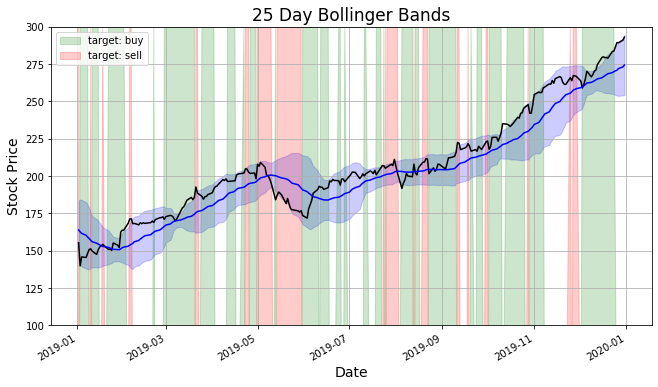

In [22]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot_date(idx19, close, 'k')
fig.autofmt_xdate()
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.tight_layout()
ax.plot_date(idx19, MA_25, 'b')
plt.fill_between(idx19, BBL25, BBU25, color='b', alpha=0.2)
plt.fill_between(idx19, 300*target, 0, color='g', alpha=0.2, label = 'target: buy')
plt.fill_between(idx19, 0, -300*target, color='r', alpha=0.2, label = 'target: sell')
plt.ylim((100, 300))
plt.title('25 Day Bollinger Bands', fontdict= {'fontsize': 17})
plt.xlabel('Date',fontdict= {'fontsize': 14})
plt.ylabel('Stock Price',fontdict= {'fontsize': 14})
ax.legend()

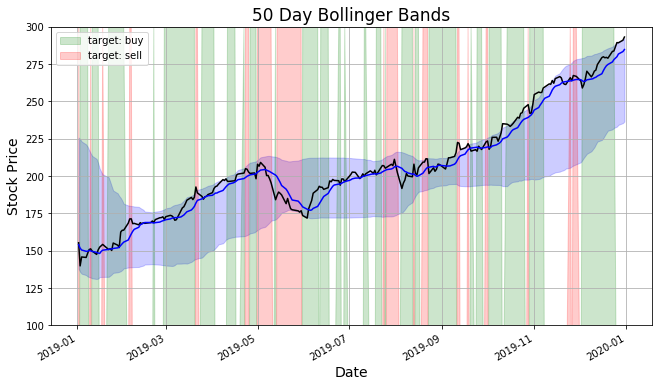

In [23]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot_date(idx19, close, 'k')
fig.autofmt_xdate()
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.tight_layout()
ax.plot_date(idx19, MA_10, 'b')
plt.fill_between(idx19, BBL50, BBU50, color='b', alpha=0.2)
plt.fill_between(idx19, 300*target, 0, color='g', alpha=0.2, label = 'target: buy')
plt.fill_between(idx19, 0, -300*target, color='r', alpha=0.2, label = 'target: sell')
plt.ylim((100, 300)) 
plt.title('50 Day Bollinger Bands', fontdict= {'fontsize': 17})
plt.xlabel('Date',fontdict= {'fontsize': 14})
plt.ylabel('Stock Price',fontdict= {'fontsize': 14})
ax.legend()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.


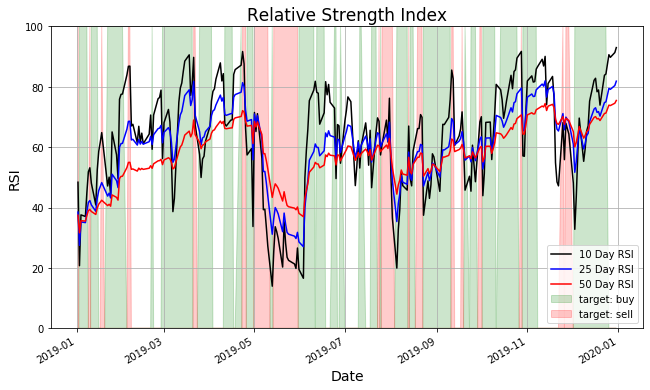

In [24]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot_date(idx19, RSI10, 'k', label = '10 Day RSI')
ax.plot_date(idx19, RSI25, 'B', label = '25 Day RSI')
ax.plot_date(idx19, RSI50, 'R', label = '50 Day RSI')
plt.fill_between(idx19, 100*target, 0, color='g', alpha=0.2, label = 'target: buy')
plt.fill_between(idx19, 0, -100*target, color='r', alpha=0.2, label = 'target: sell')

fig.autofmt_xdate()
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.tight_layout()
plt.ylim((0, 100)) 

plt.title('Relative Strength Index', fontdict= {'fontsize': 17})
plt.xlabel('Date',fontdict= {'fontsize': 14})
plt.ylabel('RSI',fontdict= {'fontsize': 14})
ax.legend()

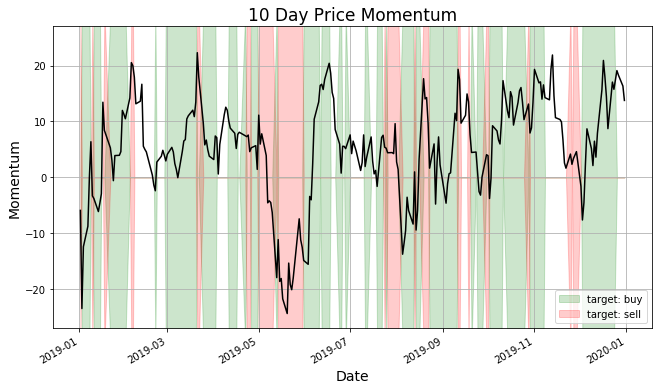

In [32]:
fig, ax = plt.subplots(figsize=(9,5))
ax.plot_date(idx19, M10, 'k')
plt.fill_between(idx19, 30*target1, -30*target1, color='g', alpha=0.2, label = 'target: buy')
plt.fill_between(idx19, 30*targetminus1, -30*targetminus1, color='r', alpha=0.2, label = 'target: sell')

fig.autofmt_xdate()
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.tight_layout()
plt.ylim((-27, 27)) 
plt.title('10 Day Price Momentum', fontdict= {'fontsize': 17})
plt.xlabel('Date',fontdict= {'fontsize': 14})
plt.ylabel('Momentum',fontdict= {'fontsize': 14})
ax.legend()